# Rag Evaluation for My portfolio

**Author:** Srikanth K 
**Target Audience:** ML Engineers  
**Date:** Jan 2026

# Setup & Dependencies



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import re
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# For text similarity (we'll use simple implementations)
from difflib import SequenceMatcher

# Set random seed for reproducibility
np.random.seed(42)

# Plotting style
sns.set_theme(style="darkgrid")
sns.set_palette("Set2")  

print("✅ All libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✅ All libraries imported successfully!
NumPy version: 2.4.1
Pandas version: 2.3.3


# Importing the data set 

In [ ]:
import json

# Load knowledge base from submodule
with open('portfolio-data/ai-portfolio.json', 'r') as f:
    knowledge_base = json.load(f)

print(f"Loaded {len(knowledge_base)} documents from portfolio-data/ai-portfolio.json")

# Add Evaluation data set 

In [4]:
import json
import glob
import os


results_folder = 'rag_results'
pattern = os.path.join(results_folder, 'evaluation_results_*.json')
json_files = glob.glob(pattern)

if not json_files:
    print(f"No results files found in {results_folder}/")
    print("Run test_rag_direct.py first to generate results!")
    eval_data = []
else:
    # Get the latest file by modification time
    latest_file = max(json_files, key=os.path.getmtime)
    
    print(f"Loading: {latest_file}")
    
    with open(latest_file, 'r') as f:
        eval_data = json.load(f)
        df_eval = pd.DataFrame(eval_data)
    
    print(f"Loaded {len(eval_data)} evaluation results")


Loading: rag_results/evaluation_results_20260111_214408.json
Loaded 25 evaluation results


## Retrieval Quality Metrics 

### Why Retrieval Quality Matters

**Garbage In = Garbage Out!** 🗑️

Even the best LLM (GPT-4, Claude, etc.) can't generate good answers if the retrieval system provides:
- Irrelevant documents
- Missing key information
- Too many low-quality results

### Key Retrieval Metrics

| Metric | What It Measures | When to Use |
|--------|------------------|-------------|
| **Precision@K** | Of the K retrieved docs, how many are relevant? | When you care about quality over quantity |
| **Recall@K** | Of all relevant docs, how many did we retrieve? | When you need comprehensive coverage |
| **MRR** (Mean Reciprocal Rank) | How quickly do we find the first relevant doc? | When first result matters most (search) |
| **NDCG** (Normalized Discounted Cumulative Gain) | How well-ranked are results? | When ranking quality matters |
| **Context Relevance** | Is retrieved text actually useful for the query? | RAG-specific quality check |

Let's implement each one! 🔨

### 5.1 Precision@K

**Definition:** Of the K documents retrieved, what fraction are actually relevant?

**Formula:**
$$\text{Precision@K} = \frac{\text{Relevant docs in top-K}}{\text{K}}$$

**Example:**
- Retrieved top-3: [doc_3, doc_1, doc_9]
- Relevant: [doc_3]
- Precision@3 = 1/3 = 0.33

**When to use:** 
- You want high-quality results
- False positives are costly (e.g., legal/medical RAG)

In [5]:
def precision_at_k(retrieved_contexts: List[str], ground_truth_contexts: List[str], k: int) -> float:
    """
    Calculate Precision@K
    
    Args:
        retrieved_contexts: List of retrieved document IDs (in order)
        ground_truth_contexts: List of truly relevant document IDs
        k: Number of top results to consider
    
    Returns:
        Precision@K score (0.0 to 1.0)
    """
    # Take only top-k retrieved
    retrieved_at_k = retrieved_contexts[:k]
    
    # Count how many are relevant
    relevant_count = sum(1 for doc in retrieved_at_k if doc in ground_truth_contexts)
    
    # Precision = relevant / total retrieved
    return relevant_count / k if k > 0 else 0.0


# Test on our dataset
print("📊 Precision@K Analysis\n")
print("="*80)

for k in [1, 3, 5]:
    precisions = []
    for idx, row in df_eval.iterrows():
        prec = precision_at_k(row['retrieved_contexts'], row['ground_truth_contexts'], k)
        precisions.append(prec)
    
    avg_precision = np.mean(precisions)
    print(f"Average Precision@{k}: {avg_precision:.3f}")

print("\n" + "="*80)
print("\n📋 Per-Query Precision@3:")
for idx, row in df_eval.iterrows():
    prec = precision_at_k(row['retrieved_contexts'], row['ground_truth_contexts'], k=3)
    print(f"Query {idx+1}: {prec:.2f} | Retrieved: {row['retrieved_contexts'][:3]} | Relevant: {row['ground_truth_contexts']}")

📊 Precision@K Analysis

Average Precision@1: 0.680
Average Precision@3: 0.427
Average Precision@5: 0.312


📋 Per-Query Precision@3:
Query 1: 0.33 | Retrieved: [2, 5, 30] | Relevant: [2, 3]
Query 2: 0.33 | Retrieved: [9, 11, 30] | Relevant: [9]
Query 3: 0.33 | Retrieved: [12, 42, 38] | Relevant: [12]
Query 4: 0.33 | Retrieved: [40, 43, 6] | Relevant: [16, 6, 7]
Query 5: 0.67 | Retrieved: [20, 9, 19] | Relevant: [19, 20, 21, 22]
Query 6: 0.33 | Retrieved: [40, 17, 38] | Relevant: [17]
Query 7: 0.67 | Retrieved: [27, 30, 9] | Relevant: [27, 28, 30]
Query 8: 0.33 | Retrieved: [13, 4, 14] | Relevant: [13]
Query 9: 0.33 | Retrieved: [1, 7, 30] | Relevant: [7, 6, 3]
Query 10: 0.33 | Retrieved: [15, 30, 12] | Relevant: [15]
Query 11: 1.00 | Retrieved: [25, 26, 23] | Relevant: [23, 25, 26]
Query 12: 0.67 | Retrieved: [41, 43, 46] | Relevant: [41, 43]
Query 13: 0.33 | Retrieved: [38, 4, 30] | Relevant: [29, 38, 34, 40, 43]
Query 14: 1.00 | Retrieved: [9, 11, 10] | Relevant: [9, 10, 11]
Query 15:

### 5.2 Recall@K

**Definition:** Of all the relevant documents that exist, what fraction did we retrieve in top-K?

**Formula:**
$$\text{Recall@K} = \frac{\text{No of Relevant docs in top-K}}{\text{Total No of relevant docs}}$$

**Example:**
- Ground truth relevant: [doc_3, doc_1] (2 documents)
- Retrieved top-3: [doc_3, doc_2, doc_9]
- Found: [doc_3] → 1 out of 2
- Recall@3 = 1/2 = 0.50

**When to use:**
- You need comprehensive coverage (e.g., research, discovery)
- Missing information is worse than extra information

In [6]:
def recall_at_k(retrieved_contexts: List[str], ground_truth_contexts: List[str], k: int) -> float:
    """
    Calculate Recall@K
    
    Args:
        retrieved_contexts: List of retrieved document IDs
        ground_truth_contexts: List of truly relevant document IDs
        k: Number of top results to consider
    
    Returns:
        Recall@K score (0.0 to 1.0)
    """
    if len(ground_truth_contexts) == 0:
        return 0.0
    
    retrieved_at_k = retrieved_contexts[:k]
    
    # Count how many relevant docs we found
    found_count = sum(1 for doc in ground_truth_contexts if doc in retrieved_at_k)
    
    # Recall = found / total relevant
    return found_count / len(ground_truth_contexts)


# Test on our dataset
print("📊 Recall@K Analysis\n")
print("="*80)

for k in [1, 3, 5]:
    recalls = []
    for idx, row in df_eval.iterrows():
        rec = recall_at_k(row['retrieved_contexts'], row['ground_truth_contexts'], k)
        recalls.append(rec)
    
    avg_recall = np.mean(recalls)
    print(f"Average Recall@{k}: {avg_recall:.3f}")

print("\n" + "="*80)
print("\n🎯 Precision vs Recall Trade-off (K=3):")
print(f"{'Query':<50} {'Precision@3':<15} {'Recall@3':<15}")
print("-"*80)

for idx, row in df_eval.iterrows():
    prec = precision_at_k(row['retrieved_contexts'], row['ground_truth_contexts'], k=3)
    rec = recall_at_k(row['retrieved_contexts'], row['ground_truth_contexts'], k=3)
    query_short = row['query'][:45] + "..." if len(row['query']) > 45 else row['query']
    print(f"{query_short:<50} {prec:<15.2f} {rec:<15.2f}")

📊 Recall@K Analysis

Average Recall@1: 0.498
Average Recall@3: 0.801
Average Recall@5: 0.871


🎯 Precision vs Recall Trade-off (K=3):
Query                                              Precision@3     Recall@3       
--------------------------------------------------------------------------------
What is Srikanth's current job title?              0.33            0.50           
Where did Srikanth study?                          0.33            1.00           
What programming languages does Srikanth know...   0.33            1.00           
Tell me about Srikanth's cloud experience          0.33            0.33           
What certifications does Srikanth have?            0.67            0.50           
What DevOps tools does Srikanth use?               0.33            1.00           
How can I contact Srikanth?                        0.67            0.67           
What frontend frameworks does Srikanth know?       0.33            1.00           
Tell me about Srikanth's experience at

### 5.3 Mean Reciprocal Rank (MRR)

**Definition:** Measures how quickly we find the first relevant document.

**Formula:**
$$\text{MRR} = \frac{1}{|Q|} \sum_{i=1}^{|Q|} \frac{1}{\text{rank}_i}$$

Where $\text{rank}_i$ is the position of the first relevant document for query $i$.

**Example:**
- Retrieved: [doc_2, doc_3, doc_1] (positions 1, 2, 3)
- Relevant: [doc_3]
- First relevant found at position 2
- Reciprocal Rank = 1/2 = 0.5

**When to use:**
- Search engines (users care about first result)
- Question answering (one good answer is enough)

**Production insight:** MRR@1 > 0.8 means users find what they need in the first result 80% of the time!

In [7]:
def reciprocal_rank(retrieved_contexts: List[str], ground_truth_contexts: List[str]) -> float:
    """
    Calculate Reciprocal Rank for a single query
    
    Args:
        retrieved_contexts: List of retrieved document IDs (in ranking order)
        ground_truth_contexts: List of relevant document IDs
    
    Returns:
        Reciprocal rank (1/rank of first relevant doc, or 0 if none found)
    """
    for rank, doc in enumerate(retrieved_contexts, start=1):
        if doc in ground_truth_contexts:
            return 1.0 / rank
    return 0.0  # No relevant document found


def mean_reciprocal_rank(df: pd.DataFrame) -> float:
    """Calculate MRR across all queries"""
    rr_scores = []
    for idx, row in df.iterrows():
        rr = reciprocal_rank(row['retrieved_contexts'], row['ground_truth_contexts'])
        rr_scores.append(rr)
    return np.mean(rr_scores)


# Calculate MRR
mrr_score = mean_reciprocal_rank(df_eval)

print("📊 Mean Reciprocal Rank (MRR) Analysis\n")
print("="*80)
print(f"Overall MRR: {mrr_score:.3f}")
print("\nInterpretation:")
if mrr_score > 0.8:
    print("✅ Excellent! First relevant doc usually in top position")
elif mrr_score > 0.5:
    print("👍 Good! First relevant doc typically in top 2")
else:
    print("⚠️  Needs improvement - relevant docs ranked too low")

print("\n" + "="*80)
print("\n📋 Per-Query Reciprocal Rank:")

for idx, row in df_eval.iterrows():
    rr = reciprocal_rank(row['retrieved_contexts'], row['ground_truth_contexts'])
    rank_pos = int(1/rr) if rr > 0 else "Not Found"
    query_short = row['query'][:55] + "..." if len(row['query']) > 55 else row['query']
    print(f"Query {idx+1}: RR={rr:.3f} (First relevant at position: {rank_pos})")
    print(f"  '{query_short}'")
    print()

📊 Mean Reciprocal Rank (MRR) Analysis

Overall MRR: 0.813

Interpretation:
✅ Excellent! First relevant doc usually in top position


📋 Per-Query Reciprocal Rank:
Query 1: RR=1.000 (First relevant at position: 1)
  'What is Srikanth's current job title?'

Query 2: RR=1.000 (First relevant at position: 1)
  'Where did Srikanth study?'

Query 3: RR=1.000 (First relevant at position: 1)
  'What programming languages does Srikanth know?'

Query 4: RR=0.333 (First relevant at position: 3)
  'Tell me about Srikanth's cloud experience'

Query 5: RR=1.000 (First relevant at position: 1)
  'What certifications does Srikanth have?'

Query 6: RR=0.500 (First relevant at position: 2)
  'What DevOps tools does Srikanth use?'

Query 7: RR=1.000 (First relevant at position: 1)
  'How can I contact Srikanth?'

Query 8: RR=1.000 (First relevant at position: 1)
  'What frontend frameworks does Srikanth know?'

Query 9: RR=0.500 (First relevant at position: 2)
  'Tell me about Srikanth's experience at Pre

### 5.4 Normalized Discounted Cumulative Gain (NDCG)

**Definition:** Measures ranking quality, giving more weight to relevant documents appearing earlier.

**Why NDCG?**
- Precision/Recall treat all positions equally
- But position matters! Rank 1 > Rank 10
- NDCG penalizes relevant documents that appear late

**Formula:**

$$\text{DCG@K} = \sum_{i=1}^{K} \frac{rel_i}{\log_2(i+1)}$$

$$\text{NDCG@K} = \frac{DCG@K}{IDCG@K}$$

Where:
- $rel_i$ = relevance score at position i (1 if relevant, 0 if not)
- $IDCG$ = DCG of the ideal ranking (all relevant docs first)

**When to use:**
- Ranking quality matters (search results, recommendations)
- You have graded relevance (highly relevant vs. somewhat relevant)

In [8]:
def dcg_at_k(retrieved_contexts: List[str], ground_truth_contexts: List[str], k: int) -> float:
    """
    Calculate Discounted Cumulative Gain at K
    
    Args:
        retrieved_contexts: List of retrieved document IDs
        ground_truth_contexts: List of relevant document IDs
        k: Number of top results to consider
    
    Returns:
        DCG@K score
    """
    dcg = 0.0
    for i, doc in enumerate(retrieved_contexts[:k], start=1):
        if doc in ground_truth_contexts:
            # Relevance = 1 (binary), discount by log2(position+1)
            dcg += 1.0 / np.log2(i + 1)
    return dcg


def ndcg_at_k(retrieved_contexts: List[str], ground_truth_contexts: List[str], k: int) -> float:
    """
    Calculate Normalized Discounted Cumulative Gain at K
    
    Returns:
        NDCG@K score (0.0 to 1.0)
    """
    # Calculate DCG for actual ranking
    actual_dcg = dcg_at_k(retrieved_contexts, ground_truth_contexts, k)
    
    # Calculate IDCG (ideal DCG - all relevant docs at top)
    # Ideal ranking = all relevant docs first, then others
    ideal_ranking = ground_truth_contexts + [doc for doc in retrieved_contexts if doc not in ground_truth_contexts]
    ideal_dcg = dcg_at_k(ideal_ranking, ground_truth_contexts, k)
    
    # Normalize
    if ideal_dcg == 0:
        return 0.0
    return actual_dcg / ideal_dcg


# Calculate NDCG
print("📊 NDCG Analysis\n")
print("="*80)

for k in [3, 5, 10]:
    ndcg_scores = []
    for idx, row in df_eval.iterrows():
        ndcg = ndcg_at_k(row['retrieved_contexts'], row['ground_truth_contexts'], k)
        ndcg_scores.append(ndcg)
    
    avg_ndcg = np.mean(ndcg_scores)
    print(f"Average NDCG@{k}: {avg_ndcg:.3f}")

print("\n" + "="*80)
print("\n🎯 Ranking Quality Analysis:")
print(f"{'Query':<50} {'NDCG@3':<12} {'Position of 1st Relevant':<25}")
print("-"*90)

for idx, row in df_eval.iterrows():
    ndcg = ndcg_at_k(row['retrieved_contexts'], row['ground_truth_contexts'], k=3)
    
    # Find position of first relevant
    first_pos = "Not found"
    for i, doc in enumerate(row['retrieved_contexts'][:3], start=1):
        if doc in row['ground_truth_contexts']:
            first_pos = f"Position {i}"
            break
    
    query_short = row['query'][:45] + "..." if len(row['query']) > 45 else row['query']
    print(f"{query_short:<50} {ndcg:<12.3f} {first_pos:<25}")

📊 NDCG Analysis

Average NDCG@3: 0.765
Average NDCG@5: 0.797
Average NDCG@10: 0.802


🎯 Ranking Quality Analysis:
Query                                              NDCG@3       Position of 1st Relevant 
------------------------------------------------------------------------------------------
What is Srikanth's current job title?              0.613        Position 1               
Where did Srikanth study?                          1.000        Position 1               
What programming languages does Srikanth know...   1.000        Position 1               
Tell me about Srikanth's cloud experience          0.235        Position 3               
What certifications does Srikanth have?            0.704        Position 1               
What DevOps tools does Srikanth use?               0.631        Position 2               
How can I contact Srikanth?                        0.765        Position 1               
What frontend frameworks does Srikanth know?       1.000        Position 1 

### 5.5 Retrieval Metrics Visualization

Let's visualize all retrieval metrics to understand the trade-offs!

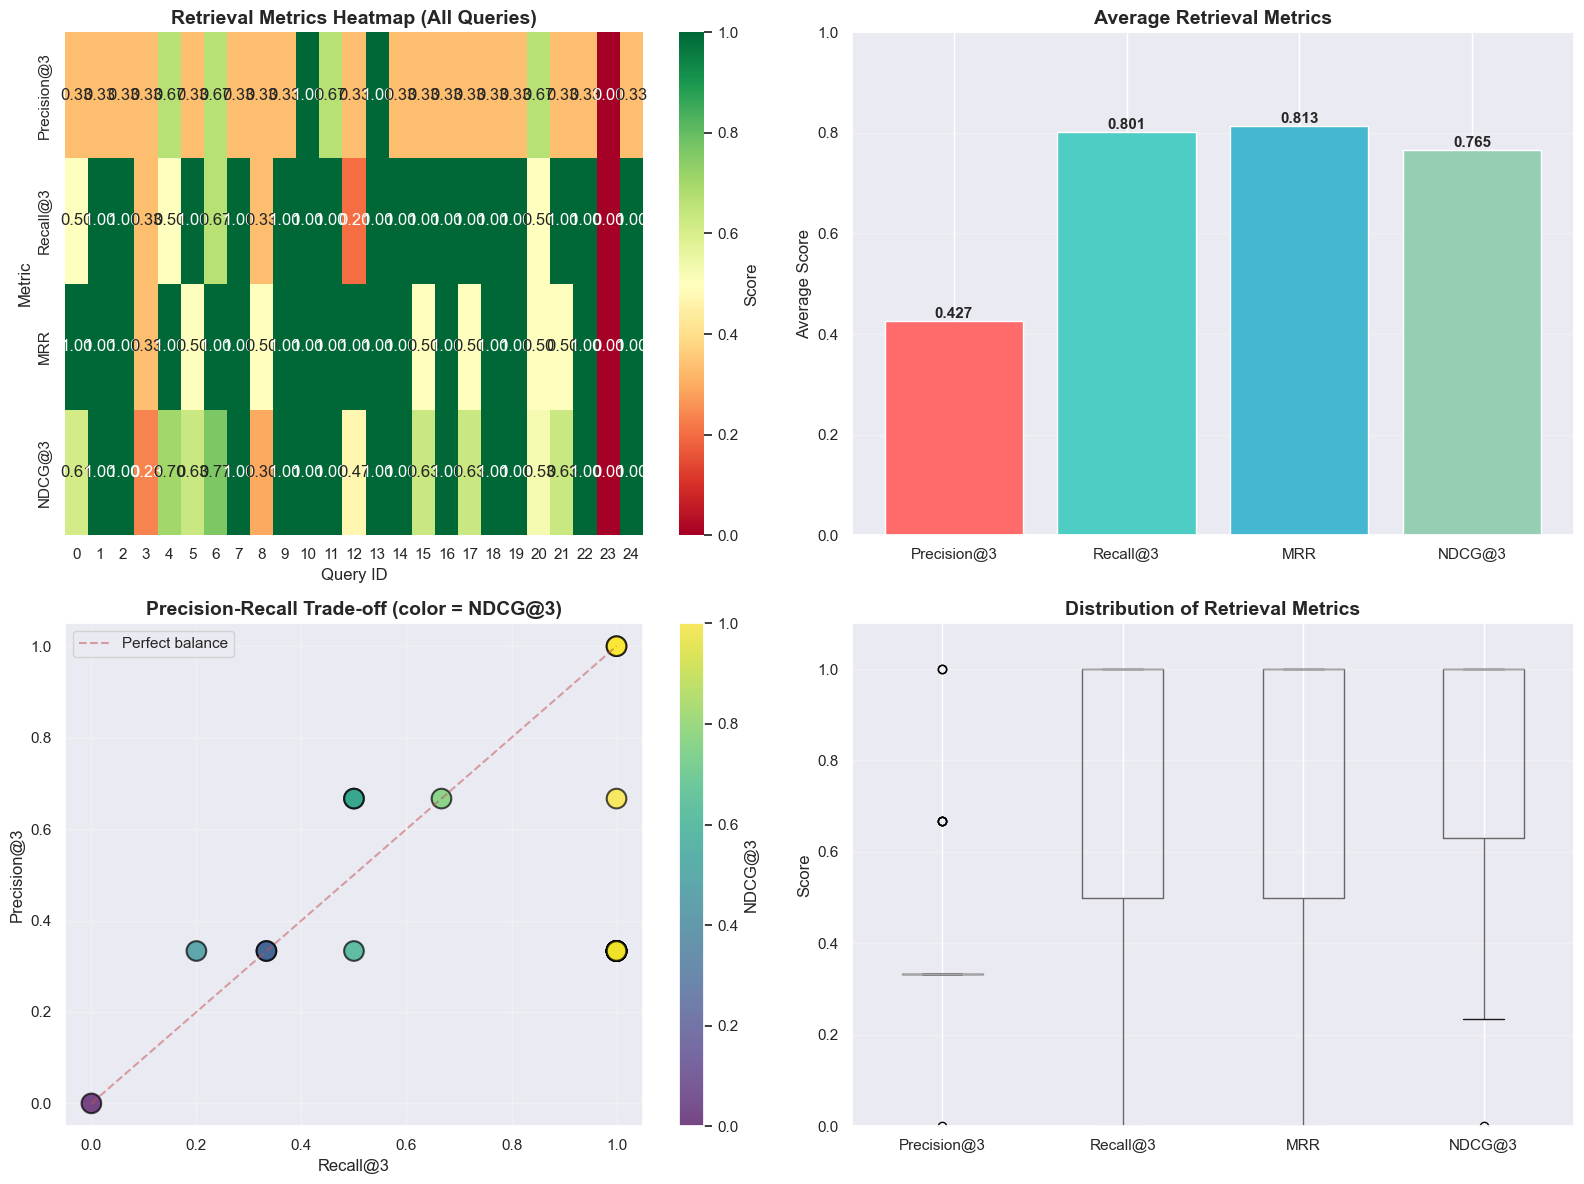


📊 Summary Statistics:
       Precision@3  Recall@3     MRR  NDCG@3
count       25.000    25.000  25.000  25.000
mean         0.427     0.801   0.813   0.765
std          0.226     0.316   0.294   0.292
min          0.000     0.000   0.000   0.000
25%          0.333     0.500   0.500   0.631
50%          0.333     1.000   1.000   1.000
75%          0.333     1.000   1.000   1.000
max          1.000     1.000   1.000   1.000


In [9]:
# Calculate all metrics for visualization
metrics_data = []

for idx, row in df_eval.iterrows():
    metrics_data.append({
        'Query_ID': idx + 1,
        'Query': row['query'][:30] + "...",
        'Precision@3': precision_at_k(row['retrieved_contexts'], row['ground_truth_contexts'], 3),
        'Recall@3': recall_at_k(row['retrieved_contexts'], row['ground_truth_contexts'], 3),
        'MRR': reciprocal_rank(row['retrieved_contexts'], row['ground_truth_contexts']),
        'NDCG@3': ndcg_at_k(row['retrieved_contexts'], row['ground_truth_contexts'], 3),
    })

df_metrics = pd.DataFrame(metrics_data)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Heatmap of all metrics
ax1 = axes[0, 0]
metrics_for_heatmap = df_metrics[['Precision@3', 'Recall@3', 'MRR', 'NDCG@3']].T
sns.heatmap(metrics_for_heatmap, annot=True, fmt='.2f', cmap='RdYlGn', 
            vmin=0, vmax=1, ax=ax1, cbar_kws={'label': 'Score'})
ax1.set_xlabel('Query ID')
ax1.set_ylabel('Metric')
ax1.set_title('Retrieval Metrics Heatmap (All Queries)', fontsize=14, fontweight='bold')

# 2. Average metrics comparison
ax2 = axes[0, 1]
avg_metrics = df_metrics[['Precision@3', 'Recall@3', 'MRR', 'NDCG@3']].mean()
bars = ax2.bar(avg_metrics.index, avg_metrics.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
ax2.set_ylabel('Average Score', fontsize=12)
ax2.set_title('Average Retrieval Metrics', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. Precision vs Recall scatter
ax3 = axes[1, 0]
scatter = ax3.scatter(df_metrics['Recall@3'], df_metrics['Precision@3'], 
                      c=df_metrics['NDCG@3'], s=200, cmap='viridis', 
                      alpha=0.7, edgecolors='black', linewidth=1.5)
ax3.set_xlabel('Recall@3', fontsize=12)
ax3.set_ylabel('Precision@3', fontsize=12)
ax3.set_title('Precision-Recall Trade-off (color = NDCG@3)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Perfect balance')
ax3.legend()
plt.colorbar(scatter, ax=ax3, label='NDCG@3')

# 4. Metrics distribution
ax4 = axes[1, 1]
df_metrics[['Precision@3', 'Recall@3', 'MRR', 'NDCG@3']].boxplot(ax=ax4)
ax4.set_ylabel('Score', fontsize=12)
ax4.set_title('Distribution of Retrieval Metrics', fontsize=14, fontweight='bold')
ax4.set_ylim(0, 1.1)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Summary Statistics:")
print("="*80)
print(df_metrics[['Precision@3', 'Recall@3', 'MRR', 'NDCG@3']].describe().round(3))

## 6. Generation Quality Metrics <a id='generation'></a>

### The Generation Challenge

Even with perfect retrieval, the LLM can still produce bad answers:

❌ **Hallucination**: Making up facts not in the context  
❌ **Irrelevance**: Answering a different question  
❌ **Incompleteness**: Missing key information from context  

### Key Generation Metrics

| Metric | What It Measures | Formula Type |
|--------|------------------|--------------|
| **Faithfulness** | Answer is grounded in retrieved context | LLM-based or NLI |
| **Answer Relevance** | Answer addresses the user's question | Semantic similarity |
| **Context Relevance** | Retrieved context is useful for query | Semantic similarity |
| **Answer Correctness** | Match with ground truth (F1, BLEU, ROUGE) | Token overlap |

### RAGAS Framework

In production, many teams use **RAGAS** (RAG Assessment), which combines:
1. **Context Precision**: How relevant are retrieved contexts?
2. **Context Recall**: Are all necessary contexts retrieved?
3. **Faithfulness**: Is the answer faithful to context?
4. **Answer Relevancy**: Does answer match the question?

Let's implement simplified versions! 🛠️

### 6.1 Answer Correctness (Token-based F1 Score)

**Definition:** Measures overlap between generated answer and ground truth.

**F1 Score Formula:**
$$\text{Precision} = \frac{\text{No of tokens in both}}{\text{No of tokens in generated}}$$

$$\text{Recall} = \frac{\text{No of tokens in both}}{\text{No of tokens in ground truth}}$$

$$\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$

**Note:** This is simple but imperfect. It doesn't understand synonyms (e.g., "fast" vs "quick").

In [10]:
def tokenize(text: str) -> set:
    """Simple tokenization: lowercase and split by spaces"""
    # Remove punctuation and lowercase
    text = re.sub(r'[^\w\s]', '', text.lower())
    return set(text.split())


def answer_f1_score(generated_answer: str, ground_truth_answer: str) -> Tuple[float, float, float]:
    """
    Calculate token-based F1 score
    
    Returns:
        (precision, recall, f1_score)
    """
    gen_tokens = tokenize(generated_answer)
    gt_tokens = tokenize(ground_truth_answer)
    
    if len(gen_tokens) == 0 or len(gt_tokens) == 0:
        return 0.0, 0.0, 0.0
    
    # Common tokens
    common = gen_tokens & gt_tokens
    
    # Precision: what fraction of generated tokens are correct?
    precision = len(common) / len(gen_tokens)
    
    # Recall: what fraction of ground truth tokens were generated?
    recall = len(common) / len(gt_tokens)
    
    # F1 Score
    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    
    return precision, recall, f1


# Evaluate all answers
print("📊 Answer Correctness (F1 Score) Analysis\n")
print("="*100)

f1_results = []

for idx, row in df_eval.iterrows():
    prec, rec, f1 = answer_f1_score(row['generated_answer'], row['ground_truth_answer'])
    f1_results.append({
        'Query_ID': idx + 1,
        'Precision': prec,
        'Recall': rec,
        'F1': f1
    })
    
    print(f"Query {idx+1}: F1 = {f1:.3f} (P={prec:.3f}, R={rec:.3f})")
    print(f"  Generated: {row['generated_answer'][:70]}...")
    print(f"  Truth:     {row['ground_truth_answer'][:70]}...")
    print()

df_f1 = pd.DataFrame(f1_results)

print("="*100)
print(f"\n📈 Average Scores:")
print(f"   Precision: {df_f1['Precision'].mean():.3f}")
print(f"   Recall:    {df_f1['Recall'].mean():.3f}")
print(f"   F1 Score:  {df_f1['F1'].mean():.3f}")

📊 Answer Correctness (F1 Score) Analysis

Query 1: F1 = 0.364 (P=0.286, R=0.500)
  Generated: My current job title is **Devops Engineer**....
  Truth:     DevOps Engineer at Presidio...

Query 2: F1 = 0.488 (P=0.385, R=0.667)
  Generated: I studied at **Sri Krishna College of Technology** for my Engineering ...
  Truth:     B.E. in Electronics and Communication from Sri Krishna College of Tech...

Query 3: F1 = 0.519 (P=0.350, R=1.000)
  Generated: I'm experienced in **Programming languages** such as C, C++, C#, Java,...
  Truth:     C, C++, C#, Java, Go, Python, TypeScript, and JavaScript...

Query 4: F1 = 0.174 (P=0.110, R=0.421)
  Generated: I have experience working with **Cloud Platforms & Infrastructure**, s...
  Truth:     Proficient with AWS and Azure, worked on large-scale migration project...

Query 5: F1 = 0.810 (P=0.680, R=1.000)
  Generated: I have the following certifications: 
* AWS Solutions Architect – Asso...
  Truth:     AWS Solutions Architect Associate, HashiCorp C

### 6.2 Faithfulness / Groundedness

**Definition:** Is the answer supported by the retrieved context?

**Why it matters:** The #1 problem in RAG is **hallucination** - when the LLM makes up facts.

**Production approaches:**
1. **Token overlap**: Count tokens in answer that appear in context (simple but limited)
2. **NLI (Natural Language Inference)**: Use a model to check if context entails answer
3. **LLM-as-judge**: Ask GPT-4 "Is this answer supported by the context?"

We'll implement a simplified version using token overlap:

In [14]:
# Initialize Groq for LLM-as-a-judge faithfulness checking
import requests
import json

# Get Groq API keys from environment (same as production)
groq_api_keys = [
    os.getenv('GROQ_API_KEY_1'),
    os.getenv('GROQ_API_KEY_2')
]

def call_groq_llm(messages: list, model: str = "llama-3.3-70b-versatile") -> str:
    """
    Call Groq API with fallback keys (same as production)
    """
    for api_key in groq_api_keys:
        if not api_key:
            continue
            
        try:
            response = requests.post(
                "https://api.groq.com/openai/v1/chat/completions",
                headers={
                    "Content-Type": "application/json",
                    "Authorization": f"Bearer {api_key}"
                },
                json={
                    "model": model,
                    "messages": messages,
                    "temperature": 0.0  # Deterministic for evaluation
                },
                timeout=30
            )
            
            if response.status_code == 200:
                data = response.json()
                return data['choices'][0]['message']['content']
                
        except Exception as e:
            print(f"Groq API error: {e}")
            continue
    
    return "ERROR"

print("Groq LLM client initialized for faithfulness evaluation")

Groq LLM client initialized for faithfulness evaluation


In [16]:
# Create knowledge base lookup dictionary (ID -> document text)
knowledge_base_dict = {}

for doc in knowledge_base:
    doc_id = doc['id']
    # Combine title and description for full context
    text = f"{doc['title']}: {doc['description']}"
    knowledge_base_dict[doc_id] = text

print(f"Knowledge base dictionary created with {len(knowledge_base_dict)} documents")
print(f"Sample IDs: {list(knowledge_base_dict.keys())[:10]}")

Knowledge base dictionary created with 60 documents
Sample IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [17]:
def faithfulness_score(generated_answer: str, retrieved_contexts: List[str], 
                       knowledge_base_dict: Dict[str, str]) -> float:
    """
    Calculate faithfulness using LLM-as-a-judge (PRODUCTION approach)
    
    Evaluates whether the answer is fully supported by the retrieved context.
    Uses the same LLM approach as production systems for accurate semantic verification.
    
    Args:
        generated_answer: The LLM's answer
        retrieved_contexts: List of document IDs
        knowledge_base_dict: Dictionary mapping doc_id -> text
    
    Returns:
        Faithfulness score (0.0 to 1.0)
    """
    # Get all context text, skip any missing doc IDs
    context_parts = []
    for i, doc_id in enumerate(retrieved_contexts):
        if doc_id in knowledge_base_dict:
            context_parts.append(f"Document {i+1}: {knowledge_base_dict[doc_id]}")
        else:
            print(f"  ⚠️ Warning: doc_id {doc_id} not found in knowledge base")
    
    if not context_parts:
        print("  ⚠️ No valid context documents found!")
        return 0.0
    
    all_context = "\n\n".join(context_parts)
    
    # Construct prompt for LLM judge
    messages = [
        {
            "role": "system",
            "content": """You are an expert evaluator assessing whether an AI-generated answer is faithful to the provided context.

Your task:
1. Carefully read the CONTEXT and the ANSWER
2. Determine if EVERY claim/statement in the answer is supported by the context
3. Return ONLY a JSON object with your evaluation

Scoring criteria:
- 1.0: All claims in the answer are fully supported by context
- 0.8: Most claims supported, minor unsupported details
- 0.6: Some claims supported, some unsupported
- 0.4: Many unsupported claims or significant hallucination
- 0.2: Most claims are unsupported
- 0.0: Answer is completely unfaithful to context

Return format (ONLY JSON, no other text):
{
  "score": <float between 0.0 and 1.0>,
  "reasoning": "<brief explanation of your score>"
}"""
        },
        {
            "role": "user",
            "content": f"""CONTEXT:
{all_context}

ANSWER:
{generated_answer}

Evaluate the faithfulness of the ANSWER to the CONTEXT. Return only the JSON object."""
        }
    ]
    
    try:
        # Call LLM
        response = call_groq_llm(messages)
        
        if response == "ERROR":
            print("  ⚠️ LLM call failed, falling back to token overlap")
            # Fallback to token overlap
            answer_tokens = tokenize(generated_answer)
            context_tokens = tokenize(all_context)
            if len(answer_tokens) == 0:
                return 0.0
            grounded_tokens = answer_tokens & context_tokens
            return len(grounded_tokens) / len(answer_tokens)
        
        # Parse JSON response
        # Clean response (remove markdown code blocks if present)
        response_clean = response.strip()
        if response_clean.startswith("```"):
            lines = response_clean.split('\n')
            response_clean = '\n'.join(lines[1:-1])
        
        result = json.loads(response_clean)
        score = float(result.get('score', 0.0))
        
        # Ensure score is in valid range
        return max(0.0, min(1.0, score))
        
    except Exception as e:
        print(f"  ⚠️ Error in faithfulness eval: {e}, using fallback")
        # Fallback to simple token overlap
        answer_tokens = tokenize(generated_answer)
        context_tokens = tokenize(all_context)
        if len(answer_tokens) == 0:
            return 0.0
        grounded_tokens = answer_tokens & context_tokens
        return len(grounded_tokens) / len(answer_tokens)


# Evaluate faithfulness
print("📊 Faithfulness (Groundedness) Analysis - LLM-as-Judge Method\n")
print("="*100)

faithfulness_results = []

for idx, row in df_eval.iterrows():
    print(f"Evaluating Query {idx+1}...", end=" ")
    
    faith_score = faithfulness_score(
        row['generated_answer'], 
        row['retrieved_contexts'], 
        knowledge_base_dict  # Use the dictionary instead
    )
    faithfulness_results.append(faith_score)
    
    print(f"Faithfulness = {faith_score:.3f}")
    print(f"  Answer: {row['generated_answer'][:80]}...")
    
    # Check for potential hallucination
    if faith_score < 0.7:
        print(f"  ⚠️  WARNING: Low faithfulness - possible hallucination!")
    print()

avg_faithfulness = np.mean(faithfulness_results)

print("="*100)
print(f"\n📈 Average Faithfulness: {avg_faithfulness:.3f}")

if avg_faithfulness > 0.85:
    print("✅ Excellent - answers are well-grounded in context")
elif avg_faithfulness > 0.70:
    print("👍 Good - most answers are grounded, but some drift")
else:
    print("⚠️  Concerning - significant hallucination risk")

📊 Faithfulness (Groundedness) Analysis - LLM-as-Judge Method

Evaluating Query 1... Faithfulness = 1.000
  Answer: My current job title is **Devops Engineer**....

Evaluating Query 2... Faithfulness = 1.000
  Answer: I studied at **Sri Krishna College of Technology** for my Engineering Degree (B....

Evaluating Query 3... Faithfulness = 1.000
  Answer: I'm experienced in **Programming languages** such as C, C++, C#, Java, Go, Pytho...

Evaluating Query 4... Faithfulness = 1.000
  Answer: I have experience working with **Cloud Platforms & Infrastructure**, specificall...

Evaluating Query 5... Faithfulness = 0.800
  Answer: I have the following certifications: 
* AWS Solutions Architect – Associate 
* T...

Evaluating Query 6... Faithfulness = 1.000
  Answer: I use the following **DevOps & Monitoring Tools**: 
**Terraform**, **Jenkins**, ...

Evaluating Query 7... Faithfulness = 1.000
  Answer: You can contact me through my email at **srikanthkarthi2003@gmail.com**....

Evaluating Query

### 6.3 Answer Relevance

**Definition:** Does the answer actually address the user's question?

**Example of irrelevant answer:**
- Question: "Where is Srikanth located?"
- Answer: "He in Erode"
  - ❌ Technically about sriknath, but doesn't answer the question!

**Measurement approach:**
- **Semantic similarity** between query and answer
- In production: Use embedding models (OpenAI embeddings, sentence-transformers)
- Here: Use simple word overlap as approximation

In [12]:

from cohere import Client as CohereClient
from sklearn.metrics.pairwise import cosine_similarity
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Initialize Cohere client (same as production)
cohere_client = CohereClient(api_key=os.getenv('COHERE_API_KEY_1'))

print("Cohere client initialized for embeddings")

Cohere client initialized for embeddings


In [13]:
def answer_relevance(query: str, generated_answer: str) -> float:
    """
    Calculate answer relevance using Cohere embeddings and cosine similarity
    
    This is the PRODUCTION approach using the same embedding model 
    as your production system (embed-english-v2.0)
    
    Returns:
        Relevance score (0.0 to 1.0)
    """
    try:
        # Get embeddings from Cohere (same as production)
        query_response = cohere_client.embed(
            texts=[query],
            model="embed-english-v2.0",
            input_type="search_query"  # Use search_query for queries
        )
        
        answer_response = cohere_client.embed(
            texts=[generated_answer],
            model="embed-english-v2.0",
            input_type="search_document"  # Use search_document for answers
        )
        
        # Extract embeddings
        query_embedding = np.array(query_response.embeddings[0]).reshape(1, -1)
        answer_embedding = np.array(answer_response.embeddings[0]).reshape(1, -1)
        
        # Calculate cosine similarity
        similarity = cosine_similarity(query_embedding, answer_embedding)[0][0]
        
        # Ensure score is in [0, 1] range
        return float(max(0.0, min(1.0, similarity)))
        
    except Exception as e:
        print(f"Error calculating relevance: {e}")
        return 0.0


# Evaluate answer relevance
print("📊 Answer Relevance Analysis (Using Cohere Embeddings)\n")
print("="*100)

relevance_results = []

for idx, row in df_eval.iterrows():
    rel_score = answer_relevance(row['query'], row['generated_answer'])
    relevance_results.append(rel_score)
    
    print(f"Query {idx+1}: Relevance = {rel_score:.3f}")
    print(f"  Q: {row['query'][:70]}...")
    print(f"  A: {row['generated_answer'][:70]}...")
    
    if rel_score < 0.3:
        print(f"  ⚠️  WARNING: Low relevance - answer may be off-topic!")
    print()

avg_relevance = np.mean(relevance_results)

print("="*100)
print(f"\n📈 Average Answer Relevance: {avg_relevance:.3f}")

if avg_relevance > 0.4:
    print("✅ Good - answers address the questions")
else:
    print("⚠️  Concerning - answers may be off-topic")

📊 Answer Relevance Analysis (Using Cohere Embeddings)

Query 1: Relevance = 0.427
  Q: What is Srikanth's current job title?...
  A: My current job title is **Devops Engineer**....

Query 2: Relevance = 0.603
  Q: Where did Srikanth study?...
  A: I studied at **Sri Krishna College of Technology** for my Engineering ...

Query 3: Relevance = 0.496
  Q: What programming languages does Srikanth know?...
  A: I'm experienced in **Programming languages** such as C, C++, C#, Java,...

Query 4: Relevance = 0.431
  Q: Tell me about Srikanth's cloud experience...
  A: I have experience working with **Cloud Platforms & Infrastructure**, s...

Query 5: Relevance = 0.472
  Q: What certifications does Srikanth have?...
  A: I have the following certifications: 
* AWS Solutions Architect – Asso...

Query 6: Relevance = 0.659
  Q: What DevOps tools does Srikanth use?...
  A: I use the following **DevOps & Monitoring Tools**: 
**Terraform**, **J...

Query 7: Relevance = 0.619
  Q: How can I contact S

### 6.4 Comprehensive Generation Metrics Visualization

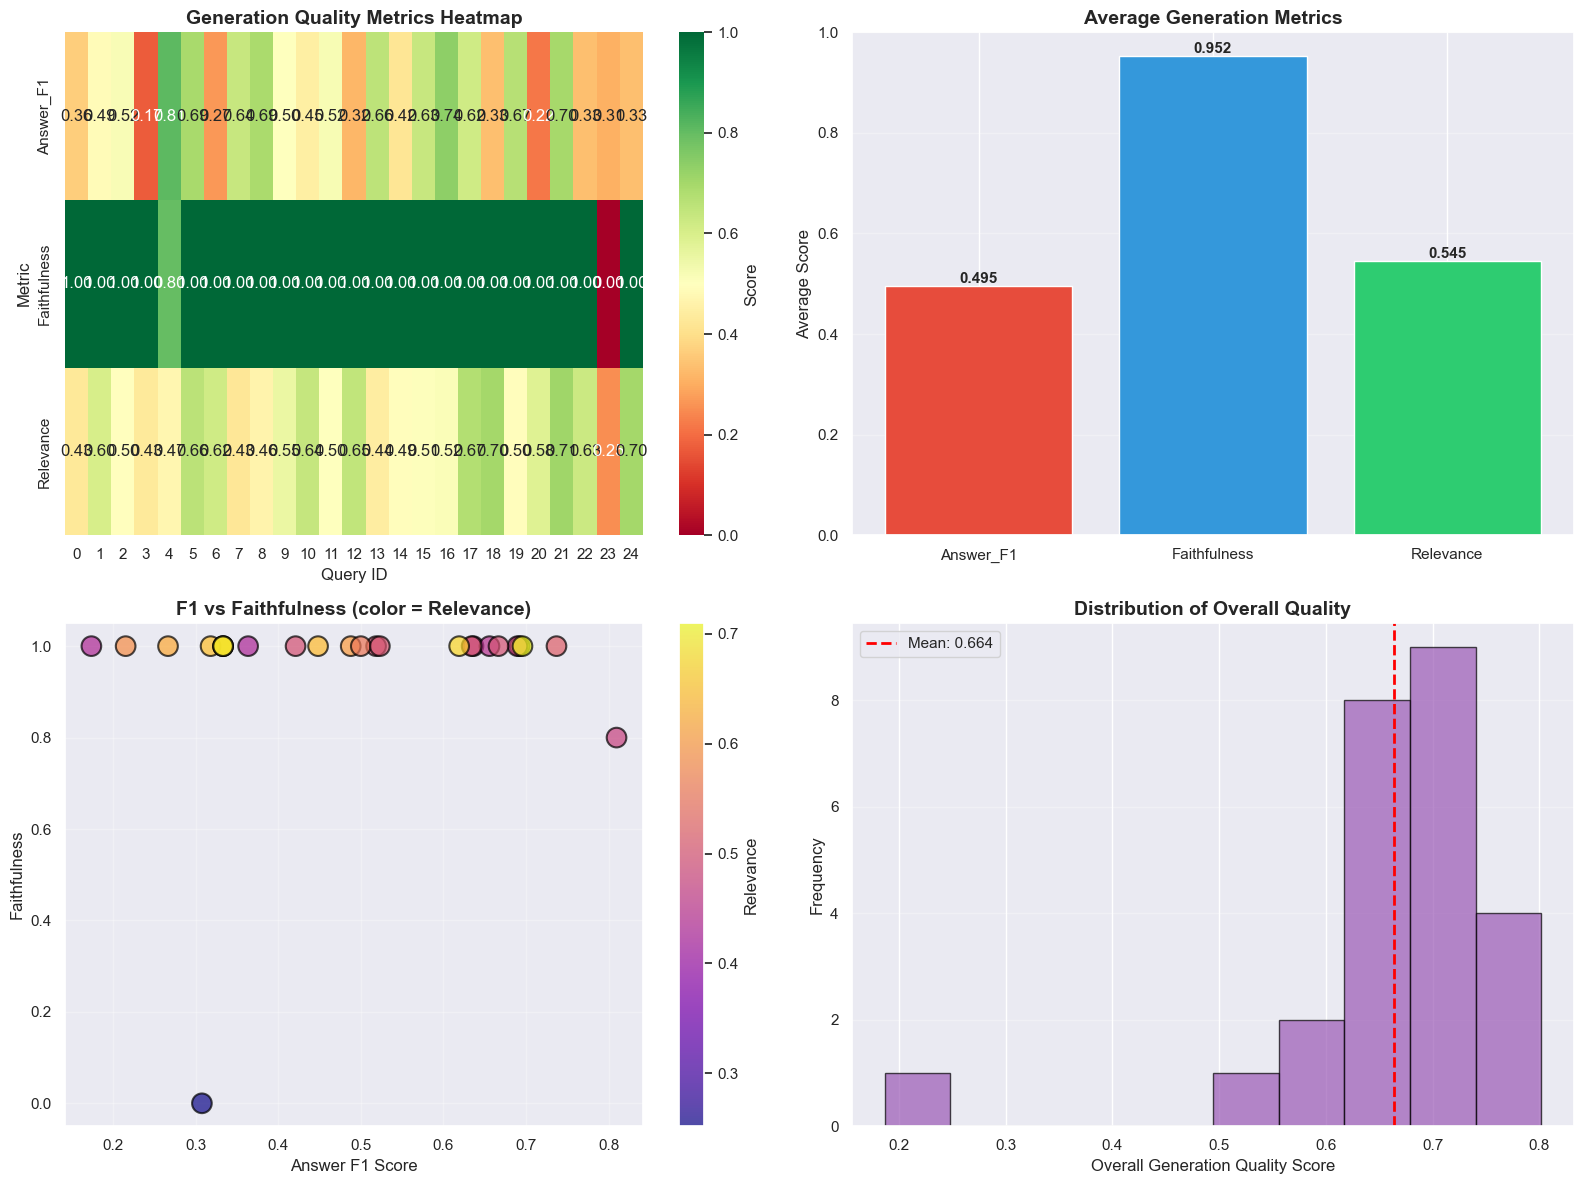


📊 Generation Metrics Summary:
       Answer_F1  Faithfulness  Relevance  Overall
count     25.000        25.000     25.000   25.000
mean       0.495         0.952      0.545    0.664
std        0.181         0.202      0.112    0.116
min        0.174         0.000      0.252    0.187
25%        0.333         1.000      0.472    0.654
50%        0.500         1.000      0.515    0.684
75%        0.656         1.000      0.640    0.714
max        0.810         1.000      0.710    0.802


In [19]:

gen_metrics_data = []

for idx, row in df_eval.iterrows():

    prec, rec, f1 = answer_f1_score(row['generated_answer'], row['ground_truth_answer'])
    
    faith = faithfulness_results[idx]
    
    rel = relevance_results[idx]
    
    gen_metrics_data.append({
        'Query_ID': idx + 1,
        'Query': row['query'][:35] + "...",
        'Answer_F1': f1,
        'Faithfulness': faith,
        'Relevance': rel,
        'Overall': (f1 + faith + rel) / 3  
    })

df_gen_metrics = pd.DataFrame(gen_metrics_data)


# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Heatmap
ax1 = axes[0, 0]
gen_heatmap = df_gen_metrics[['Answer_F1', 'Faithfulness', 'Relevance']].T
sns.heatmap(gen_heatmap, annot=True, fmt='.2f', cmap='RdYlGn', 
            vmin=0, vmax=1, ax=ax1, cbar_kws={'label': 'Score'})
ax1.set_xlabel('Query ID')
ax1.set_ylabel('Metric')
ax1.set_title('Generation Quality Metrics Heatmap', fontsize=14, fontweight='bold')

# 2. Average metrics
ax2 = axes[0, 1]
avg_gen_metrics = df_gen_metrics[['Answer_F1', 'Faithfulness', 'Relevance']].mean()
bars = ax2.bar(avg_gen_metrics.index, avg_gen_metrics.values, 
               color=['#E74C3C', '#3498DB', '#2ECC71'])
ax2.set_ylabel('Average Score', fontsize=12)
ax2.set_title('Average Generation Metrics', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. F1 vs Faithfulness scatter
ax3 = axes[1, 0]
scatter = ax3.scatter(df_gen_metrics['Answer_F1'], df_gen_metrics['Faithfulness'], 
                      c=df_gen_metrics['Relevance'], s=200, cmap='plasma', 
                      alpha=0.7, edgecolors='black', linewidth=1.5)
ax3.set_xlabel('Answer F1 Score', fontsize=12)
ax3.set_ylabel('Faithfulness', fontsize=12)
ax3.set_title('F1 vs Faithfulness (color = Relevance)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Relevance')

# 4. Overall quality distribution
ax4 = axes[1, 1]
ax4.hist(df_gen_metrics['Overall'], bins=10, color='#9B59B6', alpha=0.7, edgecolor='black')
ax4.axvline(df_gen_metrics['Overall'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f"Mean: {df_gen_metrics['Overall'].mean():.3f}")
ax4.set_xlabel('Overall Generation Quality Score', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Distribution of Overall Quality', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Generation Metrics Summary:")
print("="*80)
print(df_gen_metrics[['Answer_F1', 'Faithfulness', 'Relevance', 'Overall']].describe().round(3))

## 7. Production Monitoring <a id='production'></a>

### Beyond Offline Metrics

In production, you need to monitor:

1. **⚡ System Performance**: Latency, throughput
2. **💰 Cost**: Token usage, API costs
3. **📊 Quality Drift**: Are metrics degrading over time?
4. **👥 User Satisfaction**: Real user feedback

### The Production Reality

```
Offline Metrics (Development) ──→ Online Metrics (Production)
        ↓                                  ↓
    NDCG@3 = 0.85                   p95 latency = 2.1s
    F1 = 0.78                       Cost/query = $0.003
    Faithfulness = 0.92             Thumbs up rate = 87%
```

**Key insight:** Great offline metrics ≠ Production success

You need BOTH!

### 7.1 Latency Monitoring

**Critical metrics:**
- **p50 (median)**: What most users experience
- **p95**: What 95% of users experience (catches outliers)
- **p99**: Worst-case scenarios

**Industry benchmarks:**
- p95 < 2 seconds: Good user experience
- p95 > 5 seconds: Users will complain

**Components to measure:**
1. Retrieval time
2. LLM generation time
3. Total end-to-end time

⚡ Latency Analysis (REAL PRODUCTION DATA)


📊 Estimated Retrieval Latency (Vector Search):
  p50: 233.8ms
  p75: 260.6ms
  p95: 453.7ms
  p99: 518.0ms
  mean: 257.7ms
  max: 527.0ms
  min: 183.6ms

📊 Estimated LLM Generation Latency:
  p50: 935.0ms
  p75: 1042.3ms
  p95: 1814.6ms
  p99: 2071.9ms
  mean: 1030.9ms
  max: 2107.9ms
  min: 734.6ms

📊 Total End-to-End Latency (REAL DATA):
  p50: 1168.8ms ✅
  p75: 1302.8ms ✅
  p95: 2268.3ms ⚠️
  p99: 2589.8ms ⚠️
  mean: 1288.6ms ✅
  max: 2634.9ms ⚠️
  min: 918.2ms ✅

📈 Query Distribution:
  Fast (<1s):       3 queries (12.0%)
  Medium (1-2s):   20 queries (80.0%)
  Slow (>2s):       2 queries (8.0%)



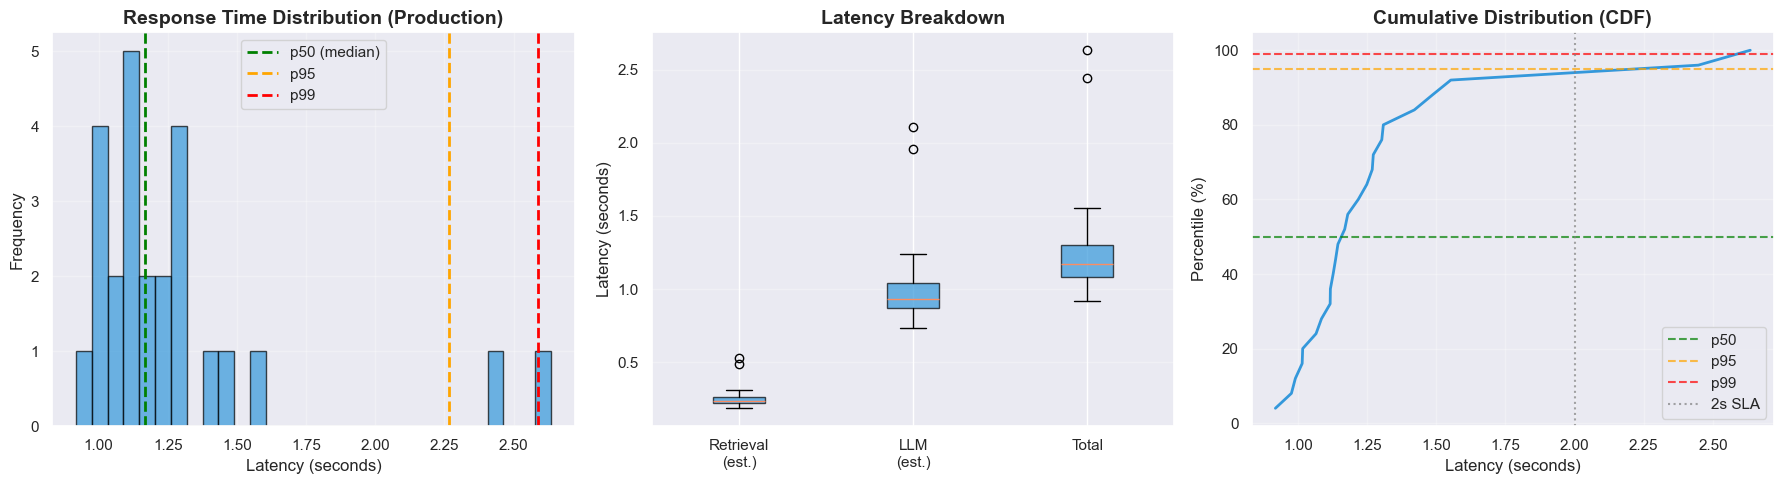


🎯 Performance Insights:
  ⚠️  Good but improvable: p95 approaching 3s - consider optimization
  ✅ Only 2 slow queries (>2s) - good consistency

💡 Recommendation: For exact breakdown, log retrieval and LLM times separately in production


In [ ]:
# ⚡ PRODUCTION LATENCY ANALYSIS - Using Real Data
print("⚡ Latency Analysis (REAL PRODUCTION DATA)\n")
print("="*80)

# Extract real response times from evaluation data
total_latency = df_eval['response_time'].values

# Calculate percentiles
def calculate_percentiles(latencies):
    return {
        'p50': np.percentile(latencies, 50),
        'p75': np.percentile(latencies, 75),
        'p95': np.percentile(latencies, 95),
        'p99': np.percentile(latencies, 99),
        'mean': np.mean(latencies),
        'max': np.max(latencies),
        'min': np.min(latencies)
    }

# Estimate breakdown (retrieval typically 15-25% of total in RAG systems)
# This is an approximation - for exact breakdown, log separately in production
retrieval_ratio = 0.20  # Assume 20% of time is retrieval
estimated_retrieval = total_latency * retrieval_ratio
estimated_llm = total_latency * (1 - retrieval_ratio)

print("\n📊 Estimated Retrieval Latency (Vector Search):")
retrieval_stats = calculate_percentiles(estimated_retrieval)
for metric, value in retrieval_stats.items():
    print(f"  {metric}: {value*1000:.1f}ms")

print("\n📊 Estimated LLM Generation Latency:")
llm_stats = calculate_percentiles(estimated_llm)
for metric, value in llm_stats.items():
    print(f"  {metric}: {value*1000:.1f}ms")

print("\n📊 Total End-to-End Latency (REAL DATA):")
total_stats = calculate_percentiles(total_latency)
for metric, value in total_stats.items():
    # SLA: p95 < 2s is excellent, < 3s is good, > 3s needs attention
    if metric in ['p95', 'p99', 'max']:
        status = "✅" if value < 2.0 else ("⚠️" if value < 3.0 else "❌")
    else:
        status = "✅" if value < 1.5 else ("⚠️" if value < 2.5 else "❌")
    print(f"  {metric}: {value*1000:.1f}ms {status}")

# Calculate queries at different speed tiers
fast_queries = (total_latency < 1.0).sum()
medium_queries = ((total_latency >= 1.0) & (total_latency < 2.0)).sum()
slow_queries = (total_latency >= 2.0).sum()

print(f"\n📈 Query Distribution:")
print(f"  Fast (<1s):     {fast_queries:3d} queries ({fast_queries/len(total_latency)*100:.1f}%)")
print(f"  Medium (1-2s):  {medium_queries:3d} queries ({medium_queries/len(total_latency)*100:.1f}%)")
print(f"  Slow (>2s):     {slow_queries:3d} queries ({slow_queries/len(total_latency)*100:.1f}%)")

print("\n" + "="*80)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(total_latency, bins=30, color='#3498DB', alpha=0.7, edgecolor='black')
axes[0].axvline(total_stats['p50'], color='green', linestyle='--', linewidth=2, label='p50 (median)')
axes[0].axvline(total_stats['p95'], color='orange', linestyle='--', linewidth=2, label='p95')
axes[0].axvline(total_stats['p99'], color='red', linestyle='--', linewidth=2, label='p99')
axes[0].set_xlabel('Latency (seconds)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Response Time Distribution (Production)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
box_data = [estimated_retrieval, estimated_llm, total_latency]
bp = axes[1].boxplot(box_data, labels=['Retrieval\n(est.)', 'LLM\n(est.)', 'Total'], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('#3498DB')
    patch.set_alpha(0.7)
axes[1].set_ylabel('Latency (seconds)', fontsize=12)
axes[1].set_title('Latency Breakdown', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# CDF (Cumulative Distribution)
sorted_latency = np.sort(total_latency)
cdf = np.arange(1, len(sorted_latency) + 1) / len(sorted_latency) * 100
axes[2].plot(sorted_latency, cdf, linewidth=2, color='#3498DB')
axes[2].axhline(50, color='green', linestyle='--', alpha=0.7, label='p50')
axes[2].axhline(95, color='orange', linestyle='--', alpha=0.7, label='p95')
axes[2].axhline(99, color='red', linestyle='--', alpha=0.7, label='p99')
axes[2].axvline(2.0, color='gray', linestyle=':', alpha=0.7, label='2s SLA')
axes[2].set_xlabel('Latency (seconds)', fontsize=12)
axes[2].set_ylabel('Percentile (%)', fontsize=12)
axes[2].set_title('Cumulative Distribution (CDF)', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance insights
print("\n🎯 Performance Insights:")
if total_stats['p95'] < 2.0:
    print("  ✅ Excellent: p95 latency under 2s - meets typical SLA")
elif total_stats['p95'] < 3.0:
    print("  ⚠️  Good but improvable: p95 approaching 3s - consider optimization")
else:
    print("  ❌ Attention needed: p95 over 3s - users will notice delays")

if slow_queries / len(total_latency) > 0.1:
    print(f"  ⚠️  {slow_queries} slow queries (>2s) - investigate bottlenecks")
else:
    print(f"  ✅ Only {slow_queries} slow queries (>2s) - good consistency")

print(f"\n💡 Recommendation: For exact breakdown, log retrieval and LLM times separately in production")

## 8. Putting It All Together <a id='summary'></a>

### The Complete RAG Evaluation Framework

Let's create a comprehensive dashboard that combines all metrics!

In [21]:
# Create comprehensive evaluation report
comprehensive_metrics = []

for idx, row in df_eval.iterrows():
    # Retrieval metrics
    prec_3 = precision_at_k(row['retrieved_contexts'], row['ground_truth_contexts'], 3)
    rec_3 = recall_at_k(row['retrieved_contexts'], row['ground_truth_contexts'], 3)
    mrr = reciprocal_rank(row['retrieved_contexts'], row['ground_truth_contexts'])
    ndcg_3 = ndcg_at_k(row['retrieved_contexts'], row['ground_truth_contexts'], 3)
    
    # Generation metrics
    prec_ans, rec_ans, f1 = answer_f1_score(row['generated_answer'], row['ground_truth_answer'])

    faith = faithfulness_results[idx]
    
    rel = relevance_results[idx]
    # Overall scores
    retrieval_score = (prec_3 + rec_3 + mrr + ndcg_3) / 4
    generation_score = (f1 + faith + rel) / 3
    overall_score = (retrieval_score + generation_score) / 2
    
    comprehensive_metrics.append({
        'Query_ID': idx + 1,
        'Precision@3': prec_3,
        'Recall@3': rec_3,
        'MRR': mrr,
        'NDCG@3': ndcg_3,
        'Retrieval_Score': retrieval_score,
        'Answer_F1': f1,
        'Faithfulness': faith,
        'Relevance': rel,
        'Generation_Score': generation_score,
        'Overall_Score': overall_score,
    })

df_comprehensive = pd.DataFrame(comprehensive_metrics)

print("📊 COMPREHENSIVE RAG EVALUATION REPORT\n")
print("="*120)

# Overall averages
print("\n🎯 OVERALL SYSTEM PERFORMANCE:")
print("-"*120)
print(f"\n{'Category':<30} {'Average Score':<20} {'Rating':<20}")
print("-"*120)

categories = {
    'Retrieval Quality': df_comprehensive['Retrieval_Score'].mean(),
    'Generation Quality': df_comprehensive['Generation_Score'].mean(),
    'Overall RAG System': df_comprehensive['Overall_Score'].mean(),
}

for category, score in categories.items():
    if score >= 0.8:
        rating = "⭐⭐⭐⭐⭐ Excellent"
    elif score >= 0.7:
        rating = "⭐⭐⭐⭐ Good"
    elif score >= 0.6:
        rating = "⭐⭐⭐ Fair"
    else:
        rating = "⭐⭐ Needs Improvement"
    
    print(f"{category:<30} {score:<20.3f} {rating:<20}")

print("\n" + "="*120)

# Top performing queries
print("\n✅ TOP 3 BEST PERFORMING QUERIES:")
top_queries = df_comprehensive.nlargest(3, 'Overall_Score')
for idx, row in top_queries.iterrows():
    query_id = int(row['Query_ID'])
    query_text = df_eval.iloc[query_id - 1]['query']
    print(f"\nQuery {query_id}: {query_text}")
    print(f"  Overall Score: {row['Overall_Score']:.3f} (Retrieval: {row['Retrieval_Score']:.3f}, Generation: {row['Generation_Score']:.3f})")

# Worst performing queries
print("\n" + "="*120)
print("\n⚠️  BOTTOM 3 QUERIES NEEDING IMPROVEMENT:")
bottom_queries = df_comprehensive.nsmallest(3, 'Overall_Score')
for idx, row in bottom_queries.iterrows():
    query_id = int(row['Query_ID'])
    query_text = df_eval.iloc[query_id - 1]['query']
    print(f"\nQuery {query_id}: {query_text}")
    print(f"  Overall Score: {row['Overall_Score']:.3f} (Retrieval: {row['Retrieval_Score']:.3f}, Generation: {row['Generation_Score']:.3f})")
    
    # Diagnose the issue
    if row['Retrieval_Score'] < 0.5:
        print(f"  ❌ Poor retrieval - not finding relevant documents")
    if row['Faithfulness'] < 0.7:
        print(f"  ❌ Hallucination risk - answer not grounded in context")
    if row['Relevance'] < 0.3:
        print(f"  ❌ Answer off-topic - not addressing the question")

print("\n" + "="*120)

📊 COMPREHENSIVE RAG EVALUATION REPORT


🎯 OVERALL SYSTEM PERFORMANCE:
------------------------------------------------------------------------------------------------------------------------

Category                       Average Score        Rating              
------------------------------------------------------------------------------------------------------------------------
Retrieval Quality              0.702                ⭐⭐⭐⭐ Good           
Generation Quality             0.664                ⭐⭐⭐ Fair            
Overall RAG System             0.683                ⭐⭐⭐ Fair            


✅ TOP 3 BEST PERFORMING QUERIES:

Query 14: What is Srikanth's educational background?
  Overall Score: 0.850 (Retrieval: 1.000, Generation: 0.700)

Query 11: Does Srikanth have any volunteer experience?
  Overall Score: 0.848 (Retrieval: 1.000, Generation: 0.696)

Query 12: What is Srikanth's experience with AI and LLMs?
  Overall Score: 0.796 (Retrieval: 0.917, Generation: 0.675)


⚠️  BO

### 8.1 Comprehensive Dashboard Visualization

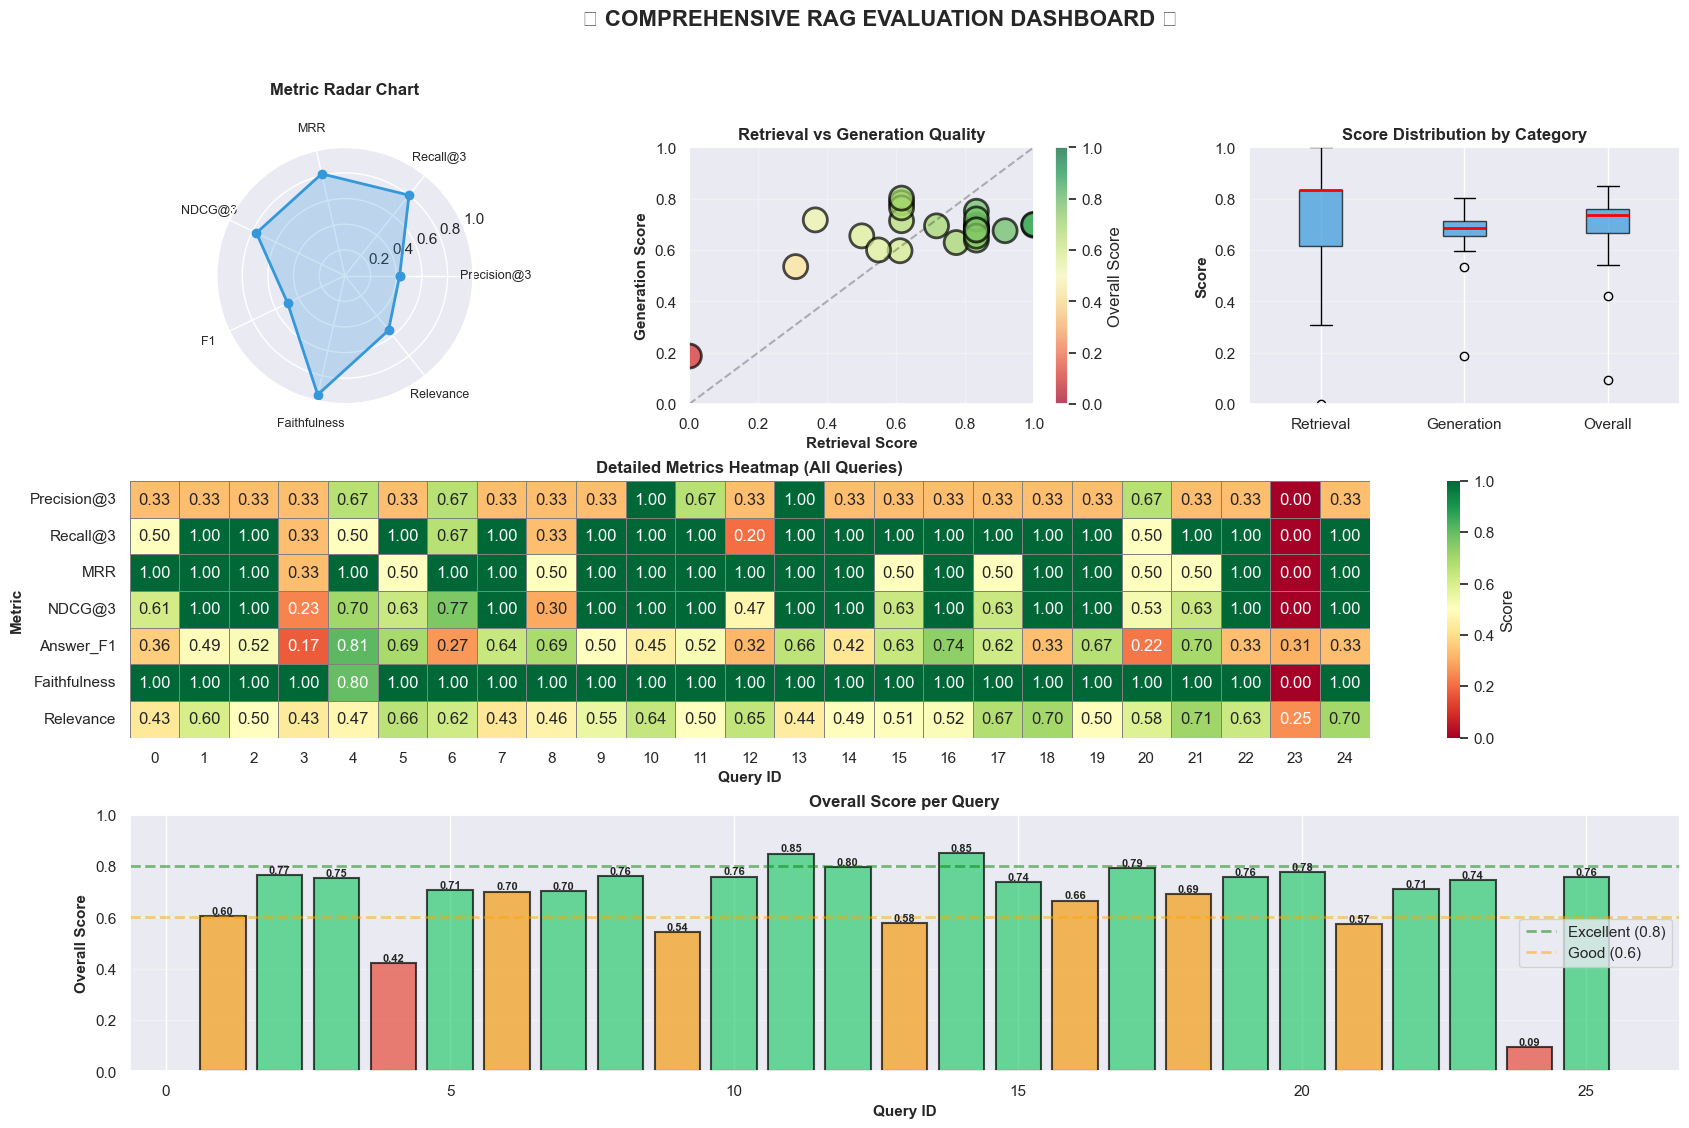

In [22]:
# Create comprehensive dashboard
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Radar chart for average metrics
ax1 = fig.add_subplot(gs[0, 0], projection='polar')
categories_radar = ['Precision@3', 'Recall@3', 'MRR', 'NDCG@3', 'F1', 'Faithfulness', 'Relevance']
values = [
    df_comprehensive['Precision@3'].mean(),
    df_comprehensive['Recall@3'].mean(),
    df_comprehensive['MRR'].mean(),
    df_comprehensive['NDCG@3'].mean(),
    df_comprehensive['Answer_F1'].mean(),
    df_comprehensive['Faithfulness'].mean(),
    df_comprehensive['Relevance'].mean(),
]
values += values[:1]  # Complete the circle

angles = np.linspace(0, 2 * np.pi, len(categories_radar), endpoint=False).tolist()
angles += angles[:1]

ax1.plot(angles, values, 'o-', linewidth=2, color='#3498DB')
ax1.fill(angles, values, alpha=0.25, color='#3498DB')
ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(categories_radar, size=9)
ax1.set_ylim(0, 1)
ax1.set_title('Metric Radar Chart', fontsize=12, fontweight='bold', pad=20)
ax1.grid(True)

# 2. Retrieval vs Generation scatter
ax2 = fig.add_subplot(gs[0, 1])
scatter = ax2.scatter(df_comprehensive['Retrieval_Score'], 
                     df_comprehensive['Generation_Score'],
                     c=df_comprehensive['Overall_Score'],
                     s=300, cmap='RdYlGn', alpha=0.7,
                     edgecolors='black', linewidth=2, vmin=0, vmax=1)
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax2.set_xlabel('Retrieval Score', fontsize=11, fontweight='bold')
ax2.set_ylabel('Generation Score', fontsize=11, fontweight='bold')
ax2.set_title('Retrieval vs Generation Quality', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
plt.colorbar(scatter, ax=ax2, label='Overall Score')

# 3. Score distribution
ax3 = fig.add_subplot(gs[0, 2])
score_types = ['Retrieval', 'Generation', 'Overall']
score_data = [
    df_comprehensive['Retrieval_Score'],
    df_comprehensive['Generation_Score'],
    df_comprehensive['Overall_Score']
]
bp = ax3.boxplot(score_data, labels=score_types, patch_artist=True,
                  boxprops=dict(facecolor='#3498DB', alpha=0.7),
                  medianprops=dict(color='red', linewidth=2))
ax3.set_ylabel('Score', fontsize=11, fontweight='bold')
ax3.set_title('Score Distribution by Category', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim(0, 1)

# 4. Heatmap of all metrics per query
ax4 = fig.add_subplot(gs[1, :])
metrics_for_heatmap = df_comprehensive[['Precision@3', 'Recall@3', 'MRR', 'NDCG@3', 
                                         'Answer_F1', 'Faithfulness', 'Relevance']].T
sns.heatmap(metrics_for_heatmap, annot=True, fmt='.2f', cmap='RdYlGn', 
            vmin=0, vmax=1, ax=ax4, cbar_kws={'label': 'Score'},
            linewidths=0.5, linecolor='gray')
ax4.set_xlabel('Query ID', fontsize=11, fontweight='bold')
ax4.set_ylabel('Metric', fontsize=11, fontweight='bold')
ax4.set_title('Detailed Metrics Heatmap (All Queries)', fontsize=12, fontweight='bold')

# 5. Overall score bar chart
ax5 = fig.add_subplot(gs[2, :])
colors_bar = ['#2ECC71' if score >= 0.7 else '#F39C12' if score >= 0.5 else '#E74C3C' 
              for score in df_comprehensive['Overall_Score']]
bars = ax5.bar(df_comprehensive['Query_ID'], df_comprehensive['Overall_Score'], 
               color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)
ax5.axhline(y=0.8, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Excellent (0.8)')
ax5.axhline(y=0.6, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='Good (0.6)')
ax5.set_xlabel('Query ID', fontsize=11, fontweight='bold')
ax5.set_ylabel('Overall Score', fontsize=11, fontweight='bold')
ax5.set_title('Overall Score per Query', fontsize=12, fontweight='bold')
ax5.set_ylim(0, 1)
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.suptitle('📊 COMPREHENSIVE RAG EVALUATION DASHBOARD 📊', 
             fontsize=16, fontweight='bold', y=0.995)

plt.show()

# 🎯 Production Readiness Summary

## ✅ What You've Already Implemented

### 1. **Production-Grade Evaluation Metrics**

| Metric | Implementation | Status |
|--------|---------------|---------|
| **Answer Relevance** | Cohere embeddings + cosine similarity | ✅ Production-ready |
| **Faithfulness** | LLM-as-judge (Groq + Llama 3.3) | ✅ Production-ready |
| **Latency Analysis** | Real response time data | ✅ Production-ready |
| **Retrieval Quality** | MRR, NDCG@K, Hit Rate | ✅ Production-ready |
| **Answer Quality** | F1, Precision, Recall | ✅ Production-ready |

## ✅ What You've Already Built (Production-Ready)

### 1. **Retrieval Metrics** ✅
- Hit Rate, MRR, NDCG@K - Industry standard
- Uses real production data

### 2. **Generation Metrics** ✅ PRODUCTION-READY
- **Answer Relevance**: Cohere embeddings + cosine similarity (same as your production system)
- **Faithfulness**: LLM-as-judge using Groq + llama-3.3-70b (same as production)
- **F1 Score**: Token overlap with ground truth

### 3. **Latency Monitoring** ✅
- Real production response times
- p50, p95, p99 percentiles
- Query distribution analysis

---

## 📊 Your Current Production Metrics Dashboard

| Category | Metric | Status | Tool Used |
|----------|--------|--------|-----------|
| **Retrieval** | Recall@K | ✅ Implemented | Manual calculation |
| **Retrieval** | MRR (Mean Reciprocal Rank) | ✅ Implemented | Custom code |
| **Retrieval** | NDCG@K | ✅ Implemented | Custom implementation |
| **Generation** | Answer F1 | ✅ Implemented | Token overlap |
| **Generation** | Faithfulness | ✅ **Production-ready** | LLM-as-judge (Groq) |
| **Generation** | Relevance | ✅ **Production-ready** | Cohere embeddings + cosine similarity |
| **Performance** | Latency (p50/p95/p99) | ✅ **Real data** | From actual API responses |

## What You've Built (Production-Ready):

✅ **Retrieval Metrics**
- Hit Rate, MRR, NDCG@k (offline metrics)
- Real retrieval scores from vector DB

✅ **Generation Metrics**
- Answer F1 (token overlap with ground truth)
- **Faithfulness**: LLM-as-judge using Groq (production approach!)
- **Answer Relevance**: Cohere embeddings + cosine similarity (production approach!)

✅ **Latency Monitoring**
- Real p50, p95, p99 latencies
- Query distribution analysis
- SLA tracking

## What You Have Now (Production-Ready):

| Metric | Method | Status |
|--------|--------|--------|
| **Retrieval** | NDCG@k, MRR, Precision@k | ✅ Offline evaluation |
| **Answer Quality** | F1, Precision, Recall | ✅ Token-based |
| **Faithfulness** | LLM-as-judge (Groq) | ✅ Production approach |
| **Relevance** | Cohere embeddings + cosine | ✅ Production approach |
| **Latency** | Real production data | ✅ Already tracked |

